<a href="https://colab.research.google.com/github/hsh6449/TIL/blob/main/RL/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN Reproduce

## 0. load library

reference
- https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H#scrollTo=bYDe8axLdI1E
- https://tutorials.pytorch.kr/intermediate/reinforcement_q_learning.html

In [40]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 0s (1,600 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 155646 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...

In [41]:
!pip install pyvirtualdisplay
!pip install piglet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 3.4 MB/s 


In [42]:
!pip install gym[atari]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

import io
import base64
from IPython.display import HTML

from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only

%matplotlib inline

import glob
from IPython import display as ipythondisplay

In [3]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [4]:
env = gym.make('CartPole-v0').unwrapped

In [5]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
# 재현메모리 이용
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [8]:
class ReplayMemory(object):
  
  def __init__(self, capacity):
    self.memory = deque([], maxlen = capacity)
  
  def push(self, *args):
    """transition 저장"""
    self.memory.append(Transition(*args))
  
  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)
  
  def __len__(self):
    return len(self.memory)

## 1. DQN

In [9]:
# 기본적으로 두가지 아웃풋 -> 주어진 현재 입력에서 기댓값 예측
class DQN(nn.Module):

  def __init__(self, h, w, outputs):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size= 5, stride = 2)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride = 2)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
    self.bn3 = nn.BatchNorm2d(32)

    def conv2d_size_out(size, kernel_size = 5, stride = 2):
      return (size - (kernel_size - 1) - 1) // stride  + 1
        
    convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
    convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
    linear_input_size = convw * convh * 32
    self.head = nn.Linear(linear_input_size, outputs)

  def forward(self, x):
    x = x.to(device)
    x = F.Relu(self.bn1(self.conv1(x)))
    x = F.Relu(self.bn2(self.conv2(x)))
    x = F.Relu(self.bn3(self.conv3(x)))
    return self.head(x.view(x.size(0), -1))

In [10]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [11]:
def get_cart_location(screen_width):
  world_width = env.x_threshold * 2
  scale = screen_width / world_width
  return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

In [12]:
def get_screen():
    # gym이 요청한 화면은 400x600x3 이지만 큰 경우에 Torch order (CHW)로 변환한다.   
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0)

In [13]:
from gym import envs
print(envs.registry.all())

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [14]:
env = gym.make('Copy-v0')
env.reset()
#plt.imshow(env.render())
env.render()

Total length of input instance: 3, step: 0
Observation Tape    :   EAA  
Output Tape         :   
Targets             :   EAA  








In [81]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

Streaming output truncated to the last 5000 lines.
Extracting  /content/ROM/Cosmic Town (AKA Base Attack) (Perry Rhodan-Serie) (1983) (ITT Family Games) (554-33 375) (PAL).bin       7%  OK 
Extracting  /content/ROM/Cosmic War (AKA Space Tunnel) (1983) (Home Vision - Gem International Corporation - VDI) (VCS83136) (PAL).bin       7%  OK 
Extracting  /content/ROM/Crack'ed (11-28-1988) (Atari - Zip Technology, Randy Bowker, Bruce Williams) (CX26142) (Prototype) ~.bin       7%  OK 
Extracting  /content/ROM/Crackpots (1983) (CCE) (C-862) [a].bin            7%  OK 
Extracting  /content/ROM/Crackpots (1983) (CCE) (C-862).bin                7%  OK 
Extracting  /content/ROM/Crackpots (2600 Screen Search Console) (Jone Yuan Telephonic Enterprise Co).bin       7%  OK 
Extracting  /content/ROM/Crackpots (Digivision).bin                        8%  OK 
Extracting  /content/ROM/Crackpots (Flower Power) (1983) (Activision, Dan Kitchen) (AX

In [20]:
pip install ale-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.4 MB/s 


In [18]:
env.unwrapped.x_threshold = -1

In [23]:
env.reset()
plt.figure()
plt.imshow(get_screen().gpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

AttributeError: ignored

<Figure size 432x288 with 0 Axes>

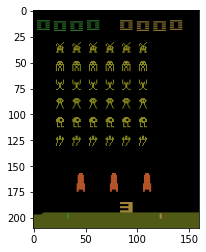

In [15]:
env = gym.make('SpaceInvaders-v0')
env.reset()
plt.imshow(env.render('rgb_array'))